<a href="https://colab.research.google.com/github/Eclipse-peach/pca-performance_mlp/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# 1. Load and Preprocess MNIST Data
print("Loading MNIST data...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype('int')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Flatten the original data for MLP input
X_train_flattened = X_train_scaled.astype('float32')
X_test_flattened = X_test_scaled.astype('float32')
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10)

# 2. Define the Multi-Layer Perceptron (MLP) Model
def create_mlp_model(input_dim):
    return tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# 3. Train the MLP Model on Original (Flattened) Data and Measure Time
print("\nTraining MLP model on original (flattened) data...")
model_mlp_original = create_mlp_model(X_train_flattened.shape[1])
model_mlp_original.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time_mlp_original = time.time()
model_mlp_original.fit(X_train_flattened, y_train_categorical, epochs=10, batch_size=32, verbose=0)
end_time_mlp_original = time.time()
training_time_mlp_original = end_time_mlp_original - start_time_mlp_original

_, accuracy_mlp_original = model_mlp_original.evaluate(X_test_flattened, y_test_categorical, verbose=0)
print(f"Original (flattened) data - Training Time: {training_time_mlp_original:.2f} seconds, Test Accuracy: {accuracy_mlp_original:.4f}")

# 4. Apply PCA to Reduce Data Dimensionality
n_components = 154  # You can experiment with the number of components
print(f"\nApplying PCA with {n_components} components...")
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 5. Train the SAME MLP Model on PCA-Reduced Data and Measure Time
print("\nTraining the SAME MLP model on PCA-reduced data...")
model_mlp_pca = create_mlp_model(n_components)
model_mlp_pca.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time_mlp_pca = time.time()
model_mlp_pca.fit(X_train_pca, y_train_categorical, epochs=10, batch_size=32, verbose=0)
end_time_mlp_pca = time.time()
training_time_mlp_pca = end_time_mlp_pca - start_time_mlp_pca

_, accuracy_mlp_pca = model_mlp_pca.evaluate(X_test_pca, y_test_categorical, verbose=0)
print(f"PCA-reduced data - Training Time: {training_time_mlp_pca:.2f} seconds, Test Accuracy: {accuracy_mlp_pca:.4f}")

print("\nComparison of Training Times (MLP):")
print(f"Original (flattened) Data Training Time: {training_time_mlp_original:.2f} seconds")
print(f"PCA-reduced Data Training Time: {training_time_mlp_pca:.2f} seconds")

Loading MNIST data...

Training MLP model on original (flattened) data...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Original (flattened) data - Training Time: 82.93 seconds, Test Accuracy: 0.9714

Applying PCA with 154 components...

Training the SAME MLP model on PCA-reduced data...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


PCA-reduced data - Training Time: 50.14 seconds, Test Accuracy: 0.9722

Comparison of Training Times (MLP):
Original (flattened) Data Training Time: 82.93 seconds
PCA-reduced Data Training Time: 50.14 seconds


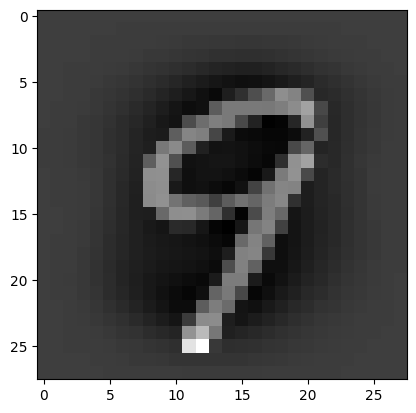

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Original MLP Model Prediction: 9


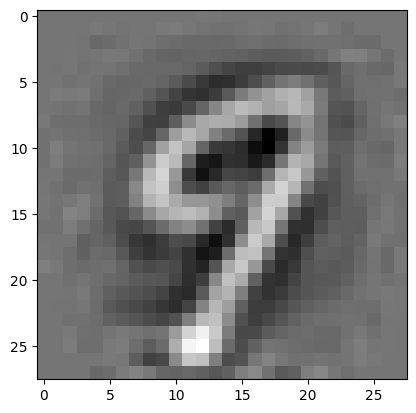

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
PCA-trained MLP Model Prediction: 9


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PIL_Image

# 5. Function to Load and Preprocess Your Handwritten Image
def preprocess_handwritten_image(image_path, target_size=(28, 28)):
    try:
        img = PIL_Image.open(image_path).convert('L')  # Convert to grayscale
        img = img.resize(target_size)
        img_array = np.array(img).astype('float32')
        img_array = 255 - img_array  # Invert pixel values (MNIST is white on black)
        return img_array
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None

# 6. Function to Preprocess for PCA Model
def preprocess_for_pca_model(image_array, pca_model, scaler_model):
    if image_array is not None:
        scaled_array = scaler_model.transform(image_array)
        pca_transformed_array = pca_model.transform(scaled_array)
        return pca_transformed_array
    return None

# 7. Function to Predict with a Given Model
def predict_digit(model, processed_image):
    if processed_image is not None:
        prediction = model.predict(processed_image)
        predicted_class = np.argmax(prediction)
        return predicted_class
    return None

test_image_display = X_train_flattened[55000].reshape(28, 28)
# Display the image using matplotlib
plt.imshow(test_image_display, cmap='gray')  # 'gray' colormap for grayscale images
plt.show()
data = X_train_flattened[55000].reshape(1,-1)
predicted_original = predict_digit(model_mlp_original, data)
print(f"Original MLP Model Prediction: {predicted_original}")

test_pca_display = pca.inverse_transform(X_train_pca[55000]).reshape(28, 28)
# Display the image using matplotlib
plt.imshow(test_pca_display, cmap='gray')  # 'gray' colormap for grayscale images
plt.show()
test_image_pca_for_prediction = X_train_pca[55000].reshape(1, -1)
predicted_pca = predict_digit(model_mlp_pca, test_image_pca_for_prediction)
if predicted_pca is not None:
  print(f"PCA-trained MLP Model Prediction: {predicted_pca}")

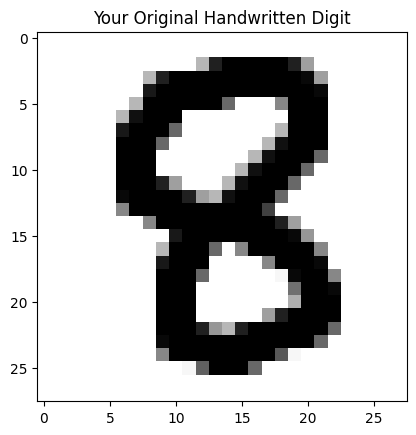

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Original MLP Model Prediction: 8


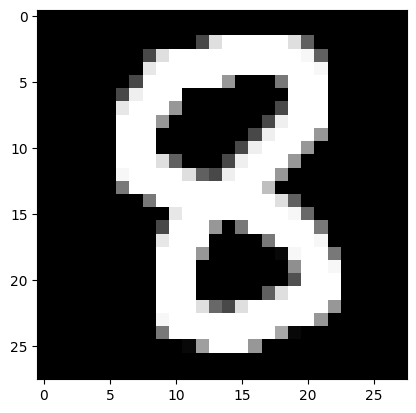

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
PCA-trained MLP Model Prediction: 8


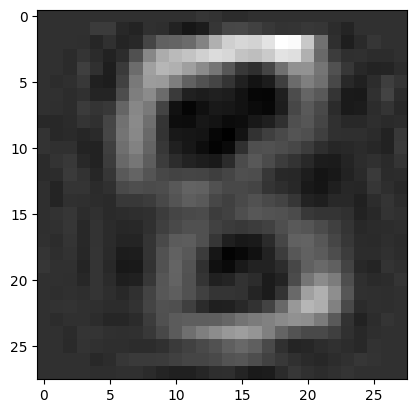

In [ ]:
if __name__ == "__main__":
    image_path = "/content/Eight_1.png"  # Replace with the actual path to your image
    try:
        original_image = PIL_Image.open(image_path).convert('L')
        plt.imshow(original_image, cmap='gray')
        plt.title("Your Original Handwritten Digit")
        plt.show()
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
    # For the original MLP model
    processed_image_original = preprocess_handwritten_image(image_path).reshape(1,-1)
    predicted_original = predict_digit(model_mlp_original, processed_image_original)
    if predicted_original is not None:
        print(f"Original MLP Model Prediction: {predicted_original}")

    test_display = preprocess_handwritten_image(image_path).reshape(28,28)
    plt.imshow(test_display, cmap='gray')
    plt.show()
    # For the PCA-trained MLP model
    processed_image_pca = preprocess_for_pca_model(processed_image_original, pca, scaler).reshape(1,-1)

    predicted_pca = predict_digit(model_mlp_pca, processed_image_pca)
    if predicted_pca is not None:
        print(f"PCA-trained MLP Model Prediction: {predicted_pca}")
    test_pca_display = pca.inverse_transform(processed_image_pca).reshape(28, 28)
    # Display the image using matplotlib
    plt.imshow(test_pca_display, cmap='gray')  # 'gray' colormap for grayscale images
    plt.show()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


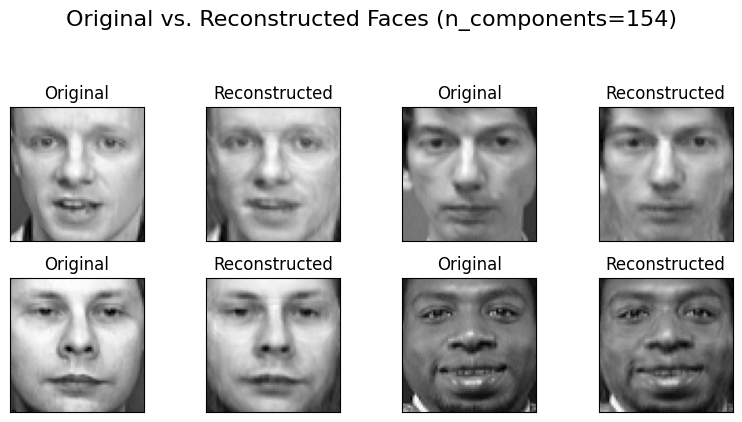

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
import numpy as np

# Load the Olivetti Faces dataset
data = fetch_olivetti_faces(shuffle=True, random_state=42)
faces_image = data.images
faces_flat = data.data
faces_target = data.target

n_samples, height, width = faces_image.shape
n_features = height * width
n_classes = len(np.unique(faces_target))

# Choose the number of principal components
n_components = 154

# Initialize and fit PCA
pca2 = PCA(n_components=n_components)
faces_reduced = pca2.fit_transform(faces_flat)

# Reconstruct the images from the reduced data
faces_reconstructed = pca2.inverse_transform(faces_reduced)
faces_reconstructed = faces_reconstructed.reshape(n_samples, height, width)

# Plot the first 10 original and reconstructed images
n_rows = 4
n_cols = 4
plt.figure(figsize=(8, 8))
plt.suptitle(f"Original vs. Reconstructed Faces (n_components={n_components})", fontsize=16)

for i in range(n_cols):
    # Original image
    plt.subplot(n_rows, n_cols, 2 * i + 1)
    plt.imshow(faces_image[i], cmap='gray')
    plt.title("Original")
    plt.xticks([])
    plt.yticks([])

    # Reconstructed image
    plt.subplot(n_rows, n_cols, 2 * i + 2)
    plt.imshow(faces_reconstructed[i], cmap='gray')
    plt.title("Reconstructed")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()